In [1]:

import warnings

import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

from pymc3 import Model, Normal, Slice, sample, Uniform, Binomial
from pymc3.distributions import Interpolated
from scipy import stats


plt.style.use("seaborn-darkgrid")
print(f"Running on PyMC3 v{pm.__version__}")

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\theano\configdefaults.py:697: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  "DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.10.0


In [2]:
# Initialize random number generator
np.random.seed(93457)

# True parameter values
alpha_true = 5
beta0_true = 7
beta1_true = 13

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha_true + beta0_true * X1 + beta1_true * X2 + np.random.randn(size)

c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 119 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>]], dtype=object)

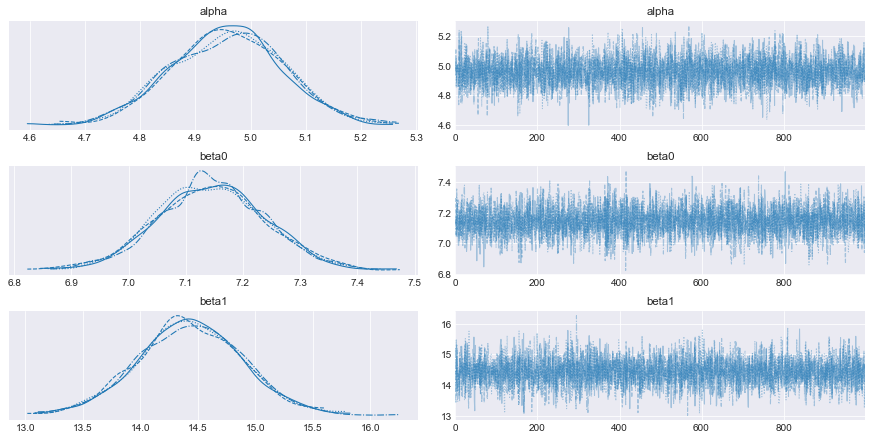

In [3]:
basic_model = Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = Normal("alpha", mu=0, sigma=1)
    beta0 = Normal("beta0", mu=12, sigma=1)
    beta1 = Normal("beta1", mu=18, sigma=1)

    # Expected value of outcome
    mu = alpha + beta0 * X1 + beta1 * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal("Y_obs", mu=mu, sigma=1, observed=Y)

    # draw 1000 posterior samples
    trace = sample(1000)
az.plot_trace(trace)

In [4]:
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return Interpolated(param, x, y)

In [5]:
traces = [trace]
for _ in range(10):
    # generate more data
    X1 = np.random.randn(size)
    X2 = np.random.randn(size) * 0.2
    Y = alpha_true + beta0_true * X1 + beta1_true * X2 + np.random.randn(size)

    model = Model()
    with model:
        # Priors are posteriors from previous iteration
        alpha = from_posterior("alpha", trace["alpha"])
        beta0 = from_posterior("beta0", trace["beta0"])
        beta1 = from_posterior("beta1", trace["beta1"])

        # Expected value of outcome
        mu = alpha + beta0 * X1 + beta1 * X2

        # Likelihood (sampling distribution) of observations
        Y_obs = Normal("Y_obs", mu=mu, sigma=1, observed=Y)

        # draw 10000 posterior samples
        trace = sample(1000)
        traces.append(trace)

c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 119 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 120 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 130 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0, alpha]


ValueError: Not enough samples to build a trace.

Posterior distributions after 8 iterations.


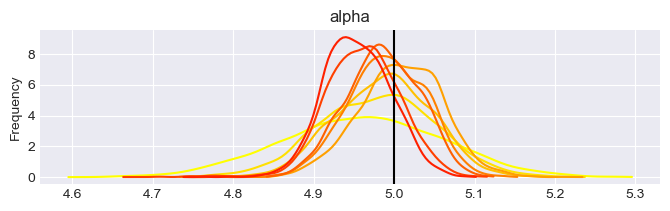

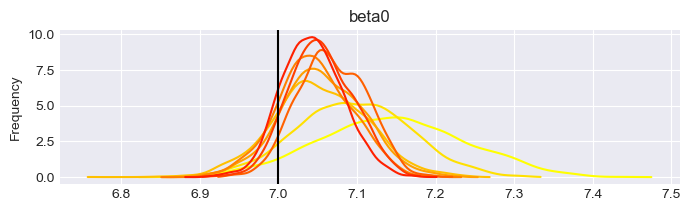

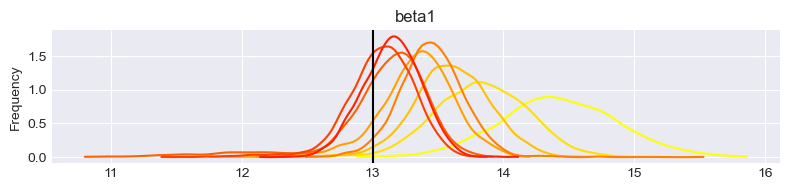

In [ ]:
print("Posterior distributions after " + str(len(traces)) + " iterations.")
cmap = mpl.cm.autumn
for param in ["alpha", "beta0", "beta1"]:
    plt.figure(figsize=(8, 2))
    for update_i, trace in enumerate(traces):
        samples = trace[param]
        smin, smax = np.min(samples), np.max(samples)
        x = np.linspace(smin, smax, 100)
        y = stats.gaussian_kde(samples)(x)
        plt.plot(x, y, color=cmap(1 - update_i / len(traces)))
    plt.axvline({"alpha": alpha_true, "beta0": beta0_true, "beta1": beta1_true}[param], c="k")
    plt.ylabel("Frequency")
    plt.title(param)

plt.tight_layout()

this is my attempt to recreate the model updating 

In [2]:
#generating 3 different planets of our solar system
# earth with 70 percent water, mars with 10 percent water and neptune with 99 percent water

# Generate data for Earth
Y_earth = np.random.binomial([1]*5000, 0.7)
water_obs_earth = np.cumsum(Y_earth)
total_obs_earth = range(1, 5001)

# Generate data for Mars
Y_mars = np.random.binomial([1]*5000, 0.1)
water_obs_mars = np.cumsum(Y_mars)
total_obs_mars = range(1, 5001)

# Generate data for Neptune
Y_neptune = np.random.binomial([1]*5000, 0.99)
water_obs_neptune = np.cumsum(Y_neptune)
total_obs_neptune = range(1, 5001)


In [3]:
set_choice = np.random.randint(2, size=5000)

# Initialize lists for water observations and total observations
water_obs_nep_mar = []
total_obs_nep_mar = []

# Loop through the set_choice array and assign water observations and total observations accordingly
for choice in set_choice:
    if choice == 0:  # Set 1
        Y = np.random.binomial(1, 0.1)  # Mars parameters used
        water_obs_nep_mar.append(Y)
        total_obs_nep_mar.append(np.sum(water_obs_nep_mar))
    else:  # Set 2
        Y = np.random.binomial(1, 0.99)  # Neptune parameters used
        water_obs_nep_mar.append(Y)
        total_obs_nep_mar.append(np.sum(water_obs_nep_mar))

# Convert lists to numpy arrays
water_obs_nep_mar = np.array(water_obs_nep_mar)
total_obs_nep_mar = np.array(total_obs_nep_mar)

# Apply the same functions to the merged data
# For example, you can calculate the cumulative sum
cumulative_water_nep_mar = np.cumsum(water_obs_nep_mar)

c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [water_percentage_merged, water_percentage neptune, water_percentage mars, water_percentage earth]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 48 seconds.
There were 194 divergences after tuning. Increase `target_accept` or reparameterize.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
There were 169 divergences after tuning. Increase `target_accept` or reparameterize.
There were 135 divergences after tuning. Increase `target_accept` or reparameterize.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'water_percentage earth'}>,
        <AxesSubplot:title={'center':'water_percentage earth'}>],
       [<AxesSubplot:title={'center':'water_percentage mars'}>,
        <AxesSubplot:title={'center':'water_percentage mars'}>],
       [<AxesSubplot:title={'center':'water_percentage neptune'}>,
        <AxesSubplot:title={'center':'water_percentage neptune'}>],
       [<AxesSubplot:title={'center':'water_percentage_merged'}>,
        <AxesSubplot:title={'center':'water_percentage_merged'}>]],
      dtype=object)

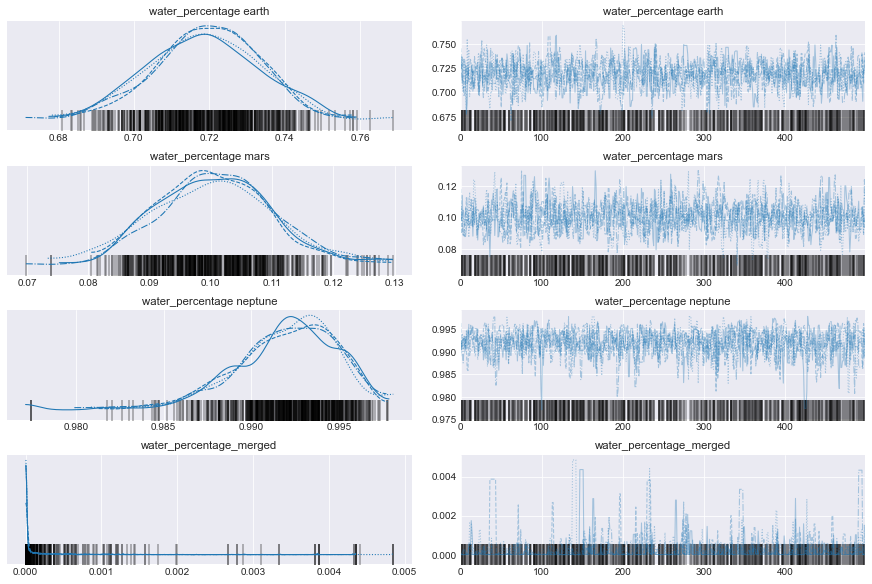

In [6]:
model_planet = Model()
with model_planet:
    #setting up the prior for each planet to be uniform
    water_percentage_earth = pm.Beta("water_percentage earth",alpha=5,beta=2)
    water_percentage_mars = pm.Beta("water_percentage mars",alpha=5,beta=2)
    water_percentage_neptune = pm.Beta("water_percentage neptune",alpha=5,beta=2)

    #trying to combine the data seems not effective
    water_percentage_merged = pm.Beta("water_percentage_merged",  alpha=water_percentage_mars,beta=water_percentage_neptune)
    #observing seperately what the estimation is
    Y_obs_earth = Binomial("Y_obs_earth",n=total_obs_earth[1000],p=water_percentage_earth,observed=water_obs_earth[1000])
    Y_obs_mars = Binomial("Y_obs_mars",n=total_obs_mars[1000],p=water_percentage_mars,observed=water_obs_mars[1000])
    Y_obs_neptune = Binomial("Y_obs_neptune",n=total_obs_neptune[1000],p=water_percentage_neptune,observed=water_obs_neptune[1000])

    #attempt to combine 2 variables in one beta function and observe using mixed data no proper results also slows down process
    Y_obs_merged = Binomial("Y_obs_neptune_mars",n=total_obs_nep_mar[1000],p=water_percentage_merged,observed=water_obs_nep_mar[1000])
    #sampling from each observed variable
    
    trace = sample(500,cores=4)

    #I don't know how to convolute these curves to form a whole yet.
az.plot_trace(trace)


5000


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [water_percentage0]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8799007598971591, but should be close to 0.8. Try to increase the number of tuning steps.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


1


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [water_percentage0]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 19 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


2


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [water_percentage0]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 18 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


3


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [water_percentage0]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 18 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


4


c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\pymc3\sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [water_percentage0]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 19 seconds.
c:\Users\herma\anaconda3\envs\PyMC3\lib\site-packages\arviz\data\io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


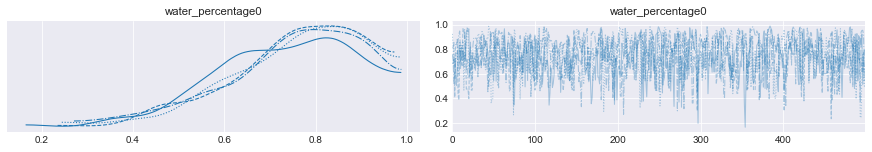

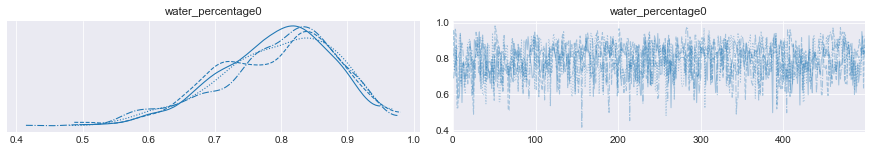

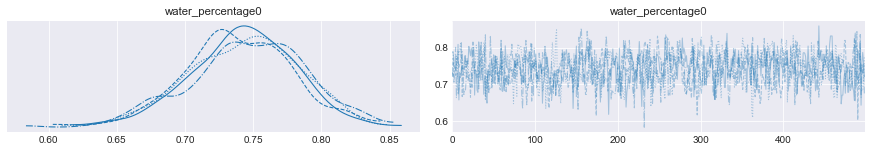

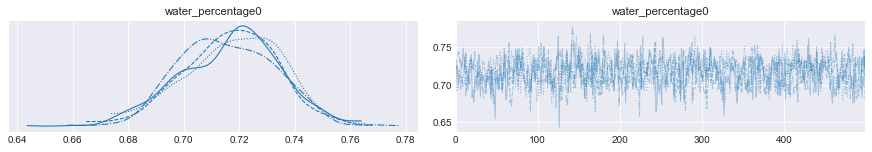

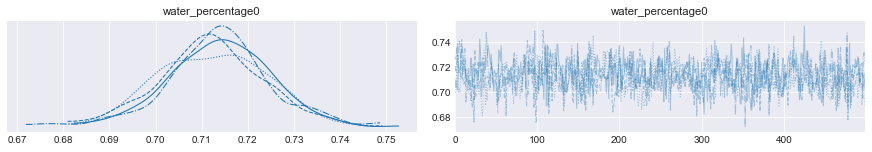

In [ ]:

Y =  np.random.binomial([1]*5000,0.7)
water_obs =  np.cumsum(Y)
total_obs = range(1,5000,1)


print(len(Y))

traces = []
vector = np.array([1,10, 100, 500,1000])
model_earth = Model()
with model_earth:
    #water_percentage = Uniform("water_percentage",0,1)
    water_percentage = pm.Beta("water_percentage"+str(0),alpha=5,beta=2)
    #water_percentage_det = pm.Deterministic("water_percentage_det",water_percentage)
    #Y_obs = Normal("Y_obs", mu=mu, sigma=1, observed=Y)

    Y_obs = Binomial("Y_obs"+str(0),n=1,p=water_percentage,observed=Y[0:vector[0]])

    trace = sample(500)
    traces.append(trace)
az.plot_trace(trace)  
for n in range(1,len(vector)):

    print(n)
    with model_earth:
         Y_obs = Binomial("Y_obs"+str(n),n=total_obs[vector[n]],p=water_percentage,observed=water_obs[vector[n]])
         trace = sample(500)
         traces.append(trace)
        

    az.plot_trace(trace)    

In [ ]:
traces = []
vector = np.array([1,10, 100, 500,1000])
model_earth = Model()
with model_earth:
    #water_percentage = Uniform("water_percentage",0,1)
    water_percentage = pm.Beta("water_percentage"+str(0),alpha=5,beta=2)
    #water_percentage_det = pm.Deterministic("water_percentage_det",water_percentage)
    #Y_obs = Normal("Y_obs", mu=mu, sigma=1, observed=Y)

    Y_obs = Binomial("Y_obs"+str(0),n=1,p=water_percentage,observed=Y[0:vector[0]])

    trace = sample(500)
    traces.append(trace)
az.plot_trace(trace)  
for n in range(1,len(vector)):

    print(n)
    with model_earth:
         Y_obs = Binomial("Y_obs"+str(n),n=1,p=water_percentage,observed=Y[0:vector[n]])
         trace = sample(500)
         traces.append(trace)
        

    az.plot_trace(trace)    



NameError: name 'Y' is not defined

In [ ]:
trial = az.convert_to_inference_data(trace)
trial.get("posterior")

Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\herma\anaconda3\envs\pymc3_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<xarray.Dataset>
Dimensions:           (chain: 4, draw: 1000)
Coordinates:
  * chain             (chain) int32 0 1 2 3
  * draw              (draw) int32 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
Data variables:
    water_percentage  (chain, draw) float64 -0.5484 0.2858 ... 2.143 0.8679
Attributes:
    created_at:                 2024-02-28T10:16:32.901725
    arviz_version:              0.13.0
    inference_library:          pymc3
    inference_library_version:  3.11.5
    sampling_time:              23.69224715232849
    tuning_steps:               1000